SHIELDMAIL — FULL K-MEANS CLUSTERING ANALYSIS
Loading dataset for clustering...
Shape: (10715, 2)
Missing: 0

Class distribution:
label
0    8697
1    2018
Name: count, dtype: int64

Vectorizing text and scaling features...
Vectorized matrix: (10715, 5000)

Finding optimal k...
k=2: silhouette=0.493
k=3: silhouette=-0.060
k=4: silhouette=-0.064
k=5: silhouette=0.147
k=6: silhouette=0.182
k=7: silhouette=0.146
k=8: silhouette=0.150

Optimal k=2

Fitting KMeans with k=2...
Silhouette=0.493, CH=73.4, DB=0.653

Cluster-Spam Ratios:
          total_samples  spam_samples  spam_ratio
cluster                                         
0                10702          2018    0.188563
1                   13             0    0.000000

Extracting keywords...
Cluster 0: subject, ect, enron, vince, com
Cluster 1: shmuel, oren, berkeley, 510 642, 642

Generating 16-panel visualization dashboard...


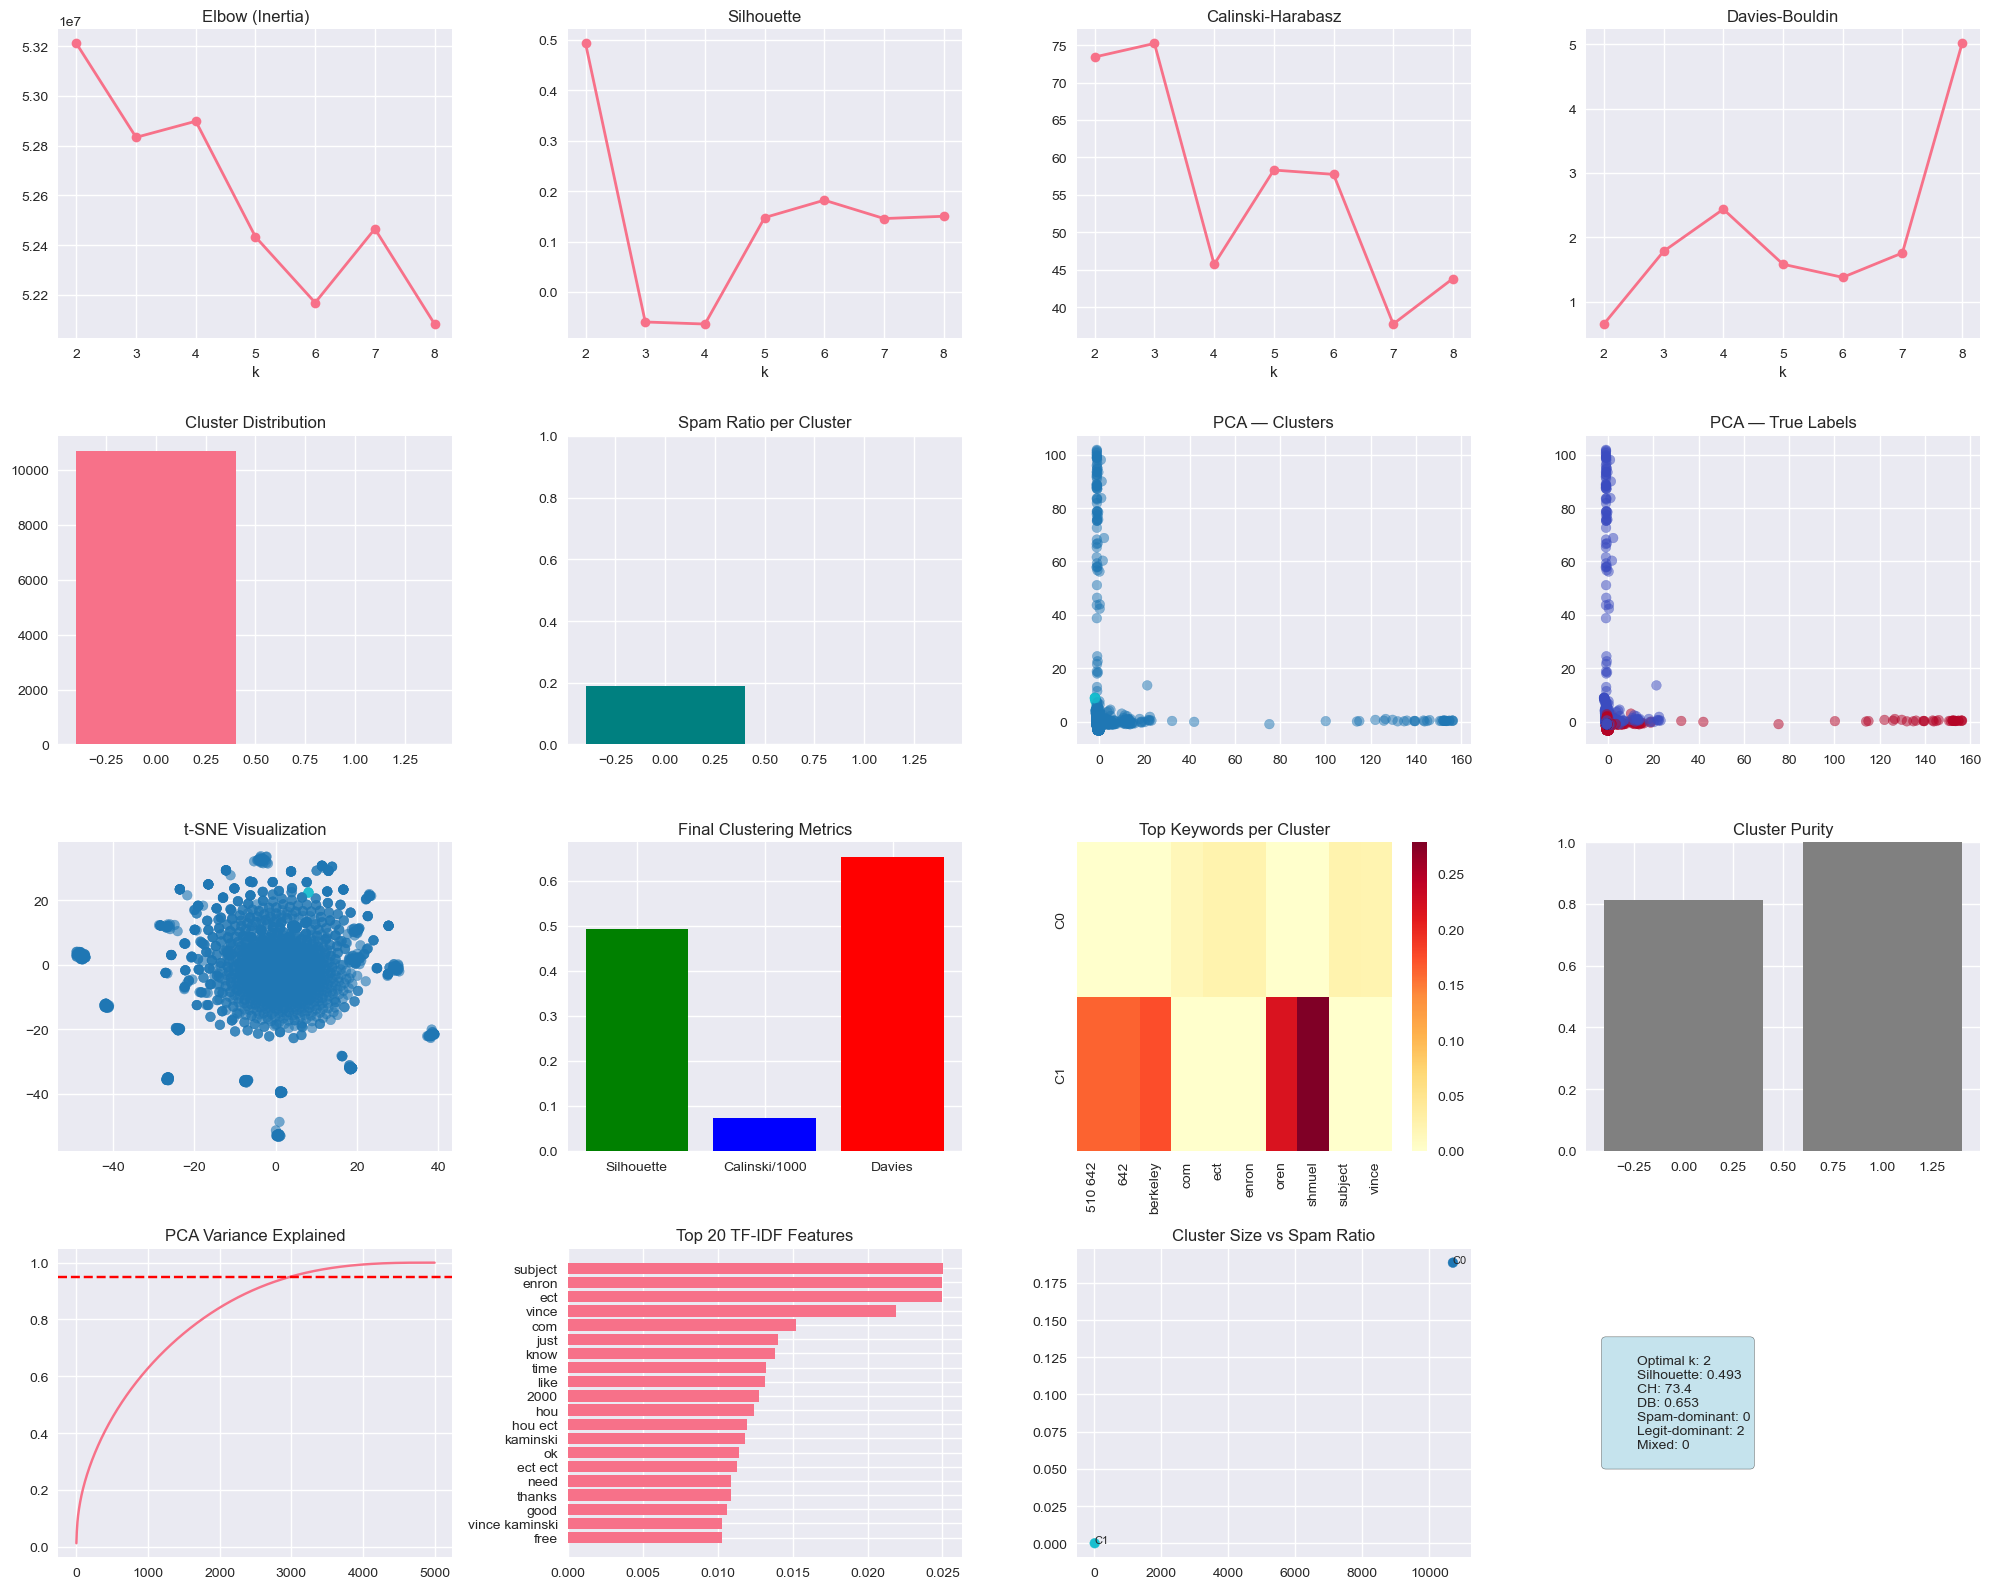

Visualization dashboard saved to /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/model_select/kmeans_clustering_evaluation.png

Saving clustering results...
All results saved under: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/model_select/

Analysis completed successfully.


In [3]:
# save as: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/data_processing/kmeans_clustering_full.py
"""
K-Means Clustering for Spam Detection Analysis
==============================================

Comprehensive K-means clustering implementation for analyzing spam patterns and grouping similar messages.
Includes evaluation metrics, keyword extraction, and 16-panel visualization dashboard.

Author: Vu Thuan Huynh-Cao Hong Dat-Le Phuoc Duy
Date: 2024
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# ---------- Universal path setup (robust to Jupyter/.py) ----------
from pathlib import Path

try:
    THIS_DIR = Path(__file__).parent
except NameError:
    THIS_DIR = Path.cwd()

def find_assignment_root(start: Path) -> Path:
    # Walk up until we hit a folder literally named "Assignment_2"
    for p in [start] + list(start.parents):
        if p.name == "Assignment_2":
            return p
    # Fallback: if not found by name, assume parent of data_processing
    return start.parent

ASSIGNMENT_ROOT  = find_assignment_root(THIS_DIR)          # .../cos30049_spam_detection/Assignment_2
PROCESSED_DIR    = ASSIGNMENT_ROOT / "outputs" / "processed"
MODEL_SELECT_DIR = ASSIGNMENT_ROOT / "outputs" / "model_select"
MODEL_SELECT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Styling ----------
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


class SpamDetectionKMeans:
    """Full-featured K-Means clustering for spam detection."""

    def __init__(self):
        self.vectorizer = None
        self.scaler = None
        self.kmeans_model = None
        self.cluster_labels = None
        self.optimal_k = None

    # ---------------- Load ----------------
    def load_data(self, data_path):
        print("Loading dataset for clustering...")
        self.data = pd.read_csv(data_path)
        print(f"Shape: {self.data.shape}")
        print("Missing:", self.data.isnull().sum().sum())
        print("\nClass distribution:")
        print(self.data["label"].value_counts())
        return self.data

    # ---------------- Preprocess ----------------
    def preprocess_data(self):
        print("\nVectorizing text and scaling features...")
        self.vectorizer = TfidfVectorizer(
            max_features=5000, stop_words="english",
            ngram_range=(1, 2), min_df=3, max_df=0.95
        )
        self.X_features = self.vectorizer.fit_transform(self.data["text"])
        self.X_dense = self.X_features.toarray()
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X_dense)
        print(f"Vectorized matrix: {self.X_scaled.shape}")

    # ---------------- Find optimal k ----------------
    def find_optimal_k(self, max_k=8):
        print("\nFinding optimal k...")
        k_vals = range(2, max_k + 1)
        self.k_range = list(k_vals)
        self.inertias, self.silhouette_scores = [], []
        self.calinski_scores, self.davies_scores = [], []

        for k in k_vals:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.X_scaled)
            self.inertias.append(kmeans.inertia_)
            self.silhouette_scores.append(silhouette_score(self.X_scaled, labels))
            self.calinski_scores.append(calinski_harabasz_score(self.X_scaled, labels))
            self.davies_scores.append(davies_bouldin_score(self.X_scaled, labels))
            print(f"k={k}: silhouette={self.silhouette_scores[-1]:.3f}")

        self.optimal_k = k_vals[np.argmax(self.silhouette_scores)]
        print(f"\nOptimal k={self.optimal_k}")
        return self.optimal_k

    # ---------------- Fit model ----------------
    def fit_kmeans(self, k=None):
        k = k or self.optimal_k
        print(f"\nFitting KMeans with k={k}...")
        self.kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
        self.cluster_labels = self.kmeans_model.fit_predict(self.X_scaled)
        self.final_silhouette = silhouette_score(self.X_scaled, self.cluster_labels)
        self.final_calinski = calinski_harabasz_score(self.X_scaled, self.cluster_labels)
        self.final_davies = davies_bouldin_score(self.X_scaled, self.cluster_labels)
        print(f"Silhouette={self.final_silhouette:.3f}, CH={self.final_calinski:.1f}, DB={self.final_davies:.3f}")

    # ---------------- Analyze clusters ----------------
    def analyze_clusters(self):
        df = pd.DataFrame({
            "text": self.data["text"],
            "label": self.data["label"],
            "cluster": self.cluster_labels
        })
        self.cluster_spam_ratio = df.groupby("cluster")["label"].agg(
            total_samples="count", spam_samples="sum", spam_ratio="mean"
        ).sort_values("spam_ratio", ascending=False)
        print("\nCluster-Spam Ratios:\n", self.cluster_spam_ratio)
        self.spam_dominant_clusters = self.cluster_spam_ratio[self.cluster_spam_ratio.spam_ratio > 0.7].index.tolist()
        self.legit_dominant_clusters = self.cluster_spam_ratio[self.cluster_spam_ratio.spam_ratio < 0.3].index.tolist()
        self.mixed_clusters = self.cluster_spam_ratio[
            (self.cluster_spam_ratio.spam_ratio >= 0.3) & (self.cluster_spam_ratio.spam_ratio <= 0.7)
        ].index.tolist()
        return df

    # ---------------- Extract keywords ----------------
    def extract_cluster_keywords(self, top_n=10):
        print("\nExtracting keywords...")
        feat_names = self.vectorizer.get_feature_names_out()
        self.cluster_keywords = {}
        for cid in range(self.optimal_k):
            mask = self.cluster_labels == cid
            mean_scores = np.array(self.X_features[mask].mean(axis=0)).flatten()
            top_idx = np.argsort(mean_scores)[-top_n:][::-1]
            self.cluster_keywords[cid] = [(feat_names[i], mean_scores[i]) for i in top_idx]
        for cid, kws in self.cluster_keywords.items():
            print(f"Cluster {cid}:", ", ".join(w for w, _ in kws[:5]))
        return self.cluster_keywords

    # ---------------- Create visualizations ----------------
    def create_visualizations(self):
        print("\nGenerating 16-panel visualization dashboard...")
        fig = plt.figure(figsize=(20, 16))

        # 1–4: Metrics vs k
        titles = ["Elbow (Inertia)", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]
        series = [self.inertias, self.silhouette_scores, self.calinski_scores, self.davies_scores]
        for i, (t, s) in enumerate(zip(titles, series), 1):
            plt.subplot(4, 4, i)
            plt.plot(self.k_range, s, "o-", lw=2)
            plt.title(t)
            plt.xlabel("k")

        # 5: Cluster counts
        plt.subplot(4, 4, 5)
        uniq, cnts = np.unique(self.cluster_labels, return_counts=True)
        plt.bar(uniq, cnts)
        plt.title("Cluster Distribution")

        # 6: Spam ratio per cluster
        plt.subplot(4, 4, 6)
        plt.bar(range(len(self.cluster_spam_ratio)), self.cluster_spam_ratio.spam_ratio, color="teal")
        plt.title("Spam Ratio per Cluster")
        plt.ylim(0, 1)

        # 7–8: PCA 2D (clusters and true labels)
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(self.X_scaled)
        plt.subplot(4, 4, 7)
        plt.scatter(X2[:, 0], X2[:, 1], c=self.cluster_labels, cmap="tab10", alpha=0.5)
        plt.title("PCA — Clusters")
        plt.subplot(4, 4, 8)
        plt.scatter(X2[:, 0], X2[:, 1], c=self.data["label"], cmap="coolwarm", alpha=0.5)
        plt.title("PCA — True Labels")

        # 9: t-SNE
        plt.subplot(4, 4, 9)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(self.X_scaled[:2000])
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.cluster_labels[:2000], cmap="tab10", alpha=0.6)
        plt.title("t-SNE Visualization")

        # 10: Cluster metrics bar
        plt.subplot(4, 4, 10)
        vals = [self.final_silhouette, self.final_calinski / 1000, self.final_davies]
        plt.bar(["Silhouette", "Calinski/1000", "Davies"], vals, color=["green", "blue", "red"])
        plt.title("Final Clustering Metrics")

        # 11: Keyword heatmap (top 5 keywords/cluster)
        plt.subplot(4, 4, 11)
        all_kws = sorted(set(sum([[w for w, _ in kws[:5]] for kws in self.cluster_keywords.values()], [])))
        mat = np.zeros((self.optimal_k, len(all_kws)))
        for cid, kws in self.cluster_keywords.items():
            for w, s in kws[:5]:
                if w in all_kws:
                    mat[cid, all_kws.index(w)] = s
        sns.heatmap(mat, xticklabels=all_kws[:10],
                    yticklabels=[f"C{i}" for i in range(self.optimal_k)],
                    cmap="YlOrRd")
        plt.title("Top Keywords per Cluster")

        # 12: Cluster purity
        plt.subplot(4, 4, 12)
        pur = []
        for cid in range(self.optimal_k):
            m = self.cluster_labels == cid
            labs = self.data["label"][m]
            pur.append(max(np.bincount(labs)) / len(labs))
        plt.bar(range(self.optimal_k), pur, color="gray")
        plt.title("Cluster Purity")
        plt.ylim(0, 1)

        # 13: PCA variance explained
        plt.subplot(4, 4, 13)
        pca_full = PCA().fit(self.X_scaled)
        csum = np.cumsum(pca_full.explained_variance_ratio_)
        plt.plot(range(1, len(csum) + 1), csum)
        plt.axhline(0.95, color="r", ls="--")
        plt.title("PCA Variance Explained")

        # 14: Top TF-IDF features
        plt.subplot(4, 4, 14)
        f_names = self.vectorizer.get_feature_names_out()
        mean_vals = np.array(self.X_features.mean(axis=0)).flatten()
        idx = np.argsort(mean_vals)[-20:]
        plt.barh([f_names[i] for i in idx], mean_vals[idx])
        plt.title("Top 20 TF-IDF Features")

        # 15: Cluster size vs spam ratio
        plt.subplot(4, 4, 15)
        s = self.cluster_spam_ratio
        plt.scatter(s.total_samples, s.spam_ratio, c=range(len(s)), cmap="tab10")
        for i, (sz, r) in enumerate(zip(s.total_samples, s.spam_ratio)):
            plt.text(sz, r, f"C{i}", fontsize=8)
        plt.title("Cluster Size vs Spam Ratio")

        # 16: Summary stats
        plt.subplot(4, 4, 16)
        txt = f"""
        Optimal k: {self.optimal_k}
        Silhouette: {self.final_silhouette:.3f}
        CH: {self.final_calinski:.1f}
        DB: {self.final_davies:.3f}
        Spam-dominant: {len(self.spam_dominant_clusters)}
        Legit-dominant: {len(self.legit_dominant_clusters)}
        Mixed: {len(self.mixed_clusters)}
        """
        plt.text(0.05, 0.5, txt, fontsize=10, va="center",
                 bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))
        plt.axis("off")

        out_png = MODEL_SELECT_DIR / "kmeans_clustering_evaluation.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Visualization dashboard saved to {out_png}")

    # ---------------- Save results ----------------
    def save_results(self):
        print("\nSaving clustering results...")
        df = pd.DataFrame({
            "text": self.data["text"],
            "label": self.data["label"],
            "cluster": self.cluster_labels
        })
        df.to_csv(MODEL_SELECT_DIR / "kmeans_cluster_assignments.csv", index=False)
        self.cluster_spam_ratio.to_csv(MODEL_SELECT_DIR / "kmeans_cluster_analysis.csv")
        pd.DataFrame({
            "k": self.k_range, "inertia": self.inertias,
            "silhouette": self.silhouette_scores,
            "calinski": self.calinski_scores,
            "davies": self.davies_scores
        }).to_csv(MODEL_SELECT_DIR / "kmeans_metrics.csv", index=False)

        if hasattr(self, "cluster_keywords"):
            rows = []
            for cid, kws in self.cluster_keywords.items():
                for w, s in kws:
                    rows.append({"cluster": cid, "keyword": w, "tfidf": s})
            pd.DataFrame(rows).to_csv(MODEL_SELECT_DIR / "kmeans_cluster_keywords.csv", index=False)

        with open(MODEL_SELECT_DIR / "kmeans_summary.txt", "w", encoding="utf-8") as f:
            f.write("K-MEANS CLUSTERING SUMMARY\n" + "=" * 40 + "\n")
            f.write(f"Optimal k: {self.optimal_k}\nSilhouette: {self.final_silhouette:.3f}\n"
                    f"Calinski: {self.final_calinski:.2f}\nDavies: {self.final_davies:.3f}\n\n")
            f.write(f"Spam clusters: {self.spam_dominant_clusters}\n"
                    f"Legit clusters: {self.legit_dominant_clusters}\n"
                    f"Mixed clusters: {self.mixed_clusters}\n")
        print(f"All results saved under: {MODEL_SELECT_DIR}/")


def main():
    print("SHIELDMAIL — FULL K-MEANS CLUSTERING ANALYSIS\n" + "=" * 60)
    model = SpamDetectionKMeans()
    data_path = PROCESSED_DIR / "emails_merged.processed.csv"
    model.load_data(data_path)
    model.preprocess_data()
    model.find_optimal_k(max_k=8)
    model.fit_kmeans()
    model.analyze_clusters()
    model.extract_cluster_keywords()
    model.create_visualizations()
    model.save_results()
    print("\nAnalysis completed successfully.\n" + "=" * 60)


if __name__ == "__main__":
    main()


SHIELDMAIL — FULL K-MEANS CLUSTERING ANALYSIS
Loading dataset for clustering...
Shape: (10715, 2)
Missing: 0

Class distribution:
label
0    8697
1    2018
Name: count, dtype: int64

Vectorizing text and scaling features...
Vectorized matrix: (10715, 5000)

Finding optimal k...
k=2: silhouette=0.493
k=3: silhouette=-0.060
k=4: silhouette=-0.064
k=5: silhouette=0.147
k=6: silhouette=0.182
k=7: silhouette=0.146
k=8: silhouette=0.150

Optimal k=2

Fitting KMeans with k=2...
Silhouette=0.493, CH=73.4, DB=0.653

Cluster-Spam Ratios:
          total_samples  spam_samples  spam_ratio
cluster                                         
0                10702          2018    0.188563
1                   13             0    0.000000

Extracting keywords...
Cluster 0: subject, ect, enron, vince, com
Cluster 1: shmuel, oren, berkeley, 510 642, 642

Generating 16-panel visualization dashboard...


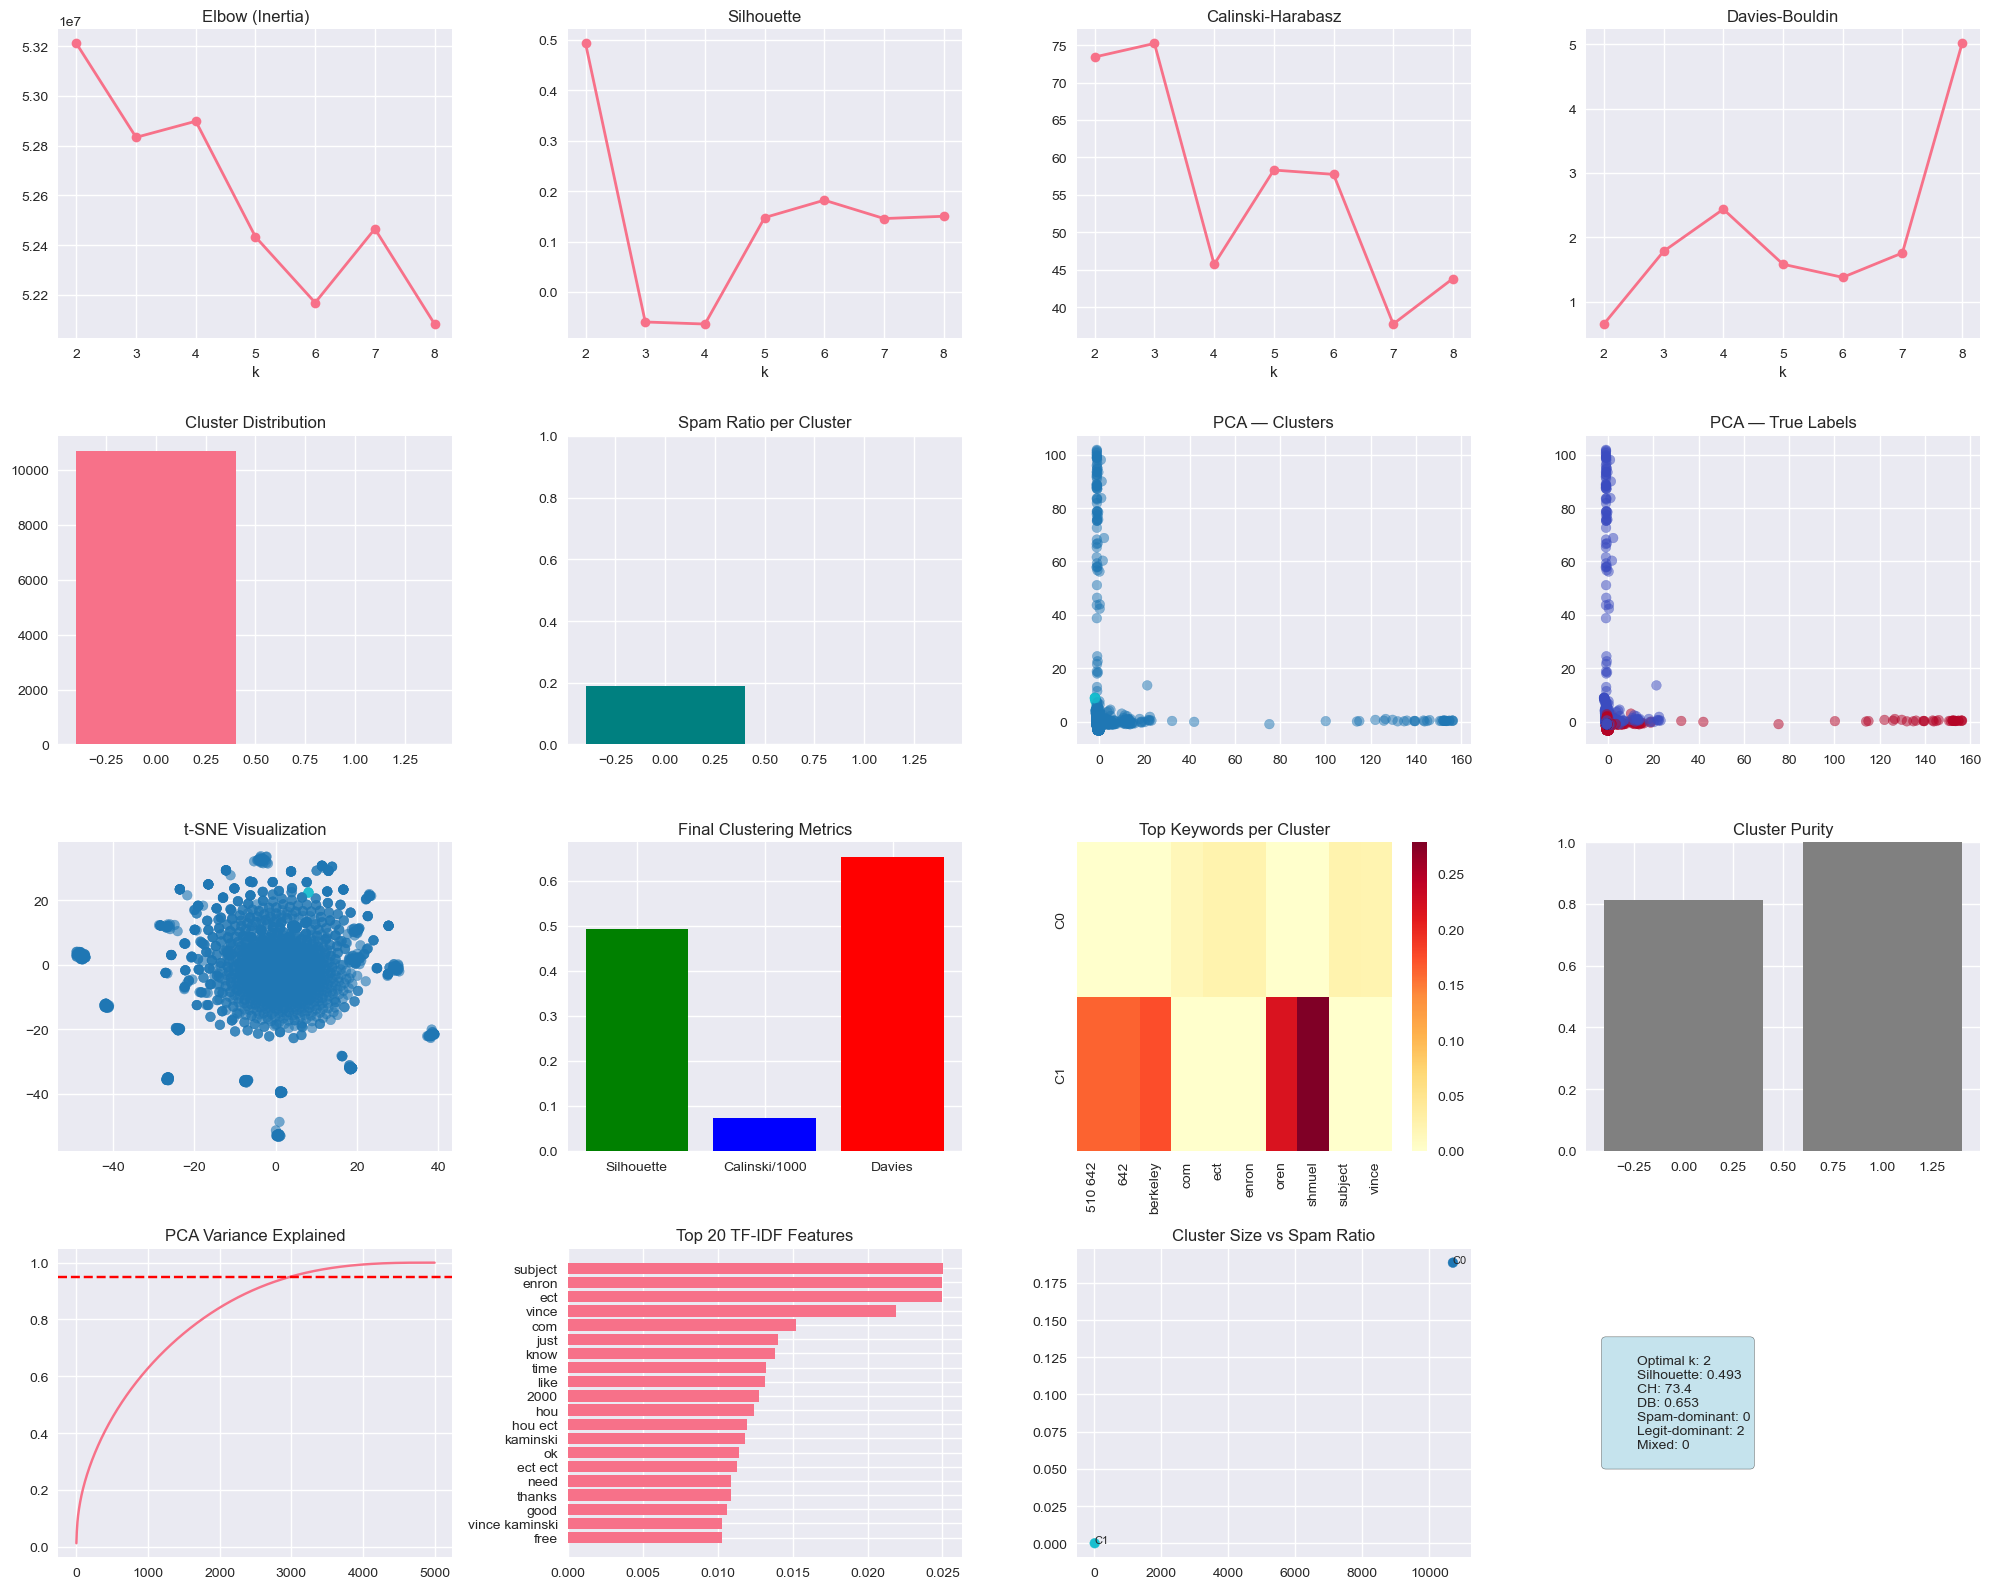

Visualization dashboard saved to /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/kmeans_test/kmeans_clustering_evaluation.png

Saving clustering results...
All results saved under: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/kmeans_test/

Analysis completed successfully.


In [4]:
# save as: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/data_processing/kmeans_clustering_full.py
"""
K-Means Clustering for Spam Detection Analysis
==============================================

Comprehensive K-means clustering implementation for analyzing spam patterns and grouping similar messages.
Includes evaluation metrics, keyword extraction, and 16-panel visualization dashboard.

Author: Vu Thuan Huynh-Cao Hong Dat-Le Phuoc Duy
Date: 2024
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# ---------- Universal path setup (KMeans -> outputs/kmeans_test) ----------
try:
    THIS_DIR = Path(__file__).parent
except NameError:
    THIS_DIR = Path.cwd()

def find_assignment_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if p.name == "Assignment_2":
            return p
    return start.parent

ASSIGNMENT_ROOT = find_assignment_root(THIS_DIR)
PROCESSED_DIR   = ASSIGNMENT_ROOT / "outputs" / "processed"
KMEANS_OUT_DIR  = ASSIGNMENT_ROOT / "outputs" / "kmeans_test"
KMEANS_OUT_DIR.mkdir(parents=True, exist_ok=True)


# ---------- Styling ----------
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


class SpamDetectionKMeans:
    """Full-featured K-Means clustering for spam detection."""

    def __init__(self):
        self.vectorizer = None
        self.scaler = None
        self.kmeans_model = None
        self.cluster_labels = None
        self.optimal_k = None

    # ---------------- Load ----------------
    def load_data(self, data_path):
        print("Loading dataset for clustering...")
        self.data = pd.read_csv(data_path)
        print(f"Shape: {self.data.shape}")
        print("Missing:", self.data.isnull().sum().sum())
        print("\nClass distribution:")
        print(self.data["label"].value_counts())
        return self.data

    # ---------------- Preprocess ----------------
    def preprocess_data(self):
        print("\nVectorizing text and scaling features...")
        self.vectorizer = TfidfVectorizer(
            max_features=5000, stop_words="english",
            ngram_range=(1, 2), min_df=3, max_df=0.95
        )
        self.X_features = self.vectorizer.fit_transform(self.data["text"])
        self.X_dense = self.X_features.toarray()
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X_dense)
        print(f"Vectorized matrix: {self.X_scaled.shape}")

    # ---------------- Find optimal k ----------------
    def find_optimal_k(self, max_k=8):
        print("\nFinding optimal k...")
        k_vals = range(2, max_k + 1)
        self.k_range = list(k_vals)
        self.inertias, self.silhouette_scores = [], []
        self.calinski_scores, self.davies_scores = [], []

        for k in k_vals:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.X_scaled)
            self.inertias.append(kmeans.inertia_)
            self.silhouette_scores.append(silhouette_score(self.X_scaled, labels))
            self.calinski_scores.append(calinski_harabasz_score(self.X_scaled, labels))
            self.davies_scores.append(davies_bouldin_score(self.X_scaled, labels))
            print(f"k={k}: silhouette={self.silhouette_scores[-1]:.3f}")

        self.optimal_k = k_vals[np.argmax(self.silhouette_scores)]
        print(f"\nOptimal k={self.optimal_k}")
        return self.optimal_k

    # ---------------- Fit model ----------------
    def fit_kmeans(self, k=None):
        k = k or self.optimal_k
        print(f"\nFitting KMeans with k={k}...")
        self.kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
        self.cluster_labels = self.kmeans_model.fit_predict(self.X_scaled)
        self.final_silhouette = silhouette_score(self.X_scaled, self.cluster_labels)
        self.final_calinski = calinski_harabasz_score(self.X_scaled, self.cluster_labels)
        self.final_davies = davies_bouldin_score(self.X_scaled, self.cluster_labels)
        print(f"Silhouette={self.final_silhouette:.3f}, CH={self.final_calinski:.1f}, DB={self.final_davies:.3f}")

    # ---------------- Analyze clusters ----------------
    def analyze_clusters(self):
        df = pd.DataFrame({
            "text": self.data["text"],
            "label": self.data["label"],
            "cluster": self.cluster_labels
        })
        self.cluster_spam_ratio = df.groupby("cluster")["label"].agg(
            total_samples="count", spam_samples="sum", spam_ratio="mean"
        ).sort_values("spam_ratio", ascending=False)
        print("\nCluster-Spam Ratios:\n", self.cluster_spam_ratio)
        self.spam_dominant_clusters = self.cluster_spam_ratio[self.cluster_spam_ratio.spam_ratio > 0.7].index.tolist()
        self.legit_dominant_clusters = self.cluster_spam_ratio[self.cluster_spam_ratio.spam_ratio < 0.3].index.tolist()
        self.mixed_clusters = self.cluster_spam_ratio[
            (self.cluster_spam_ratio.spam_ratio >= 0.3) & (self.cluster_spam_ratio.spam_ratio <= 0.7)
        ].index.tolist()
        return df

    # ---------------- Extract keywords ----------------
    def extract_cluster_keywords(self, top_n=10):
        print("\nExtracting keywords...")
        feat_names = self.vectorizer.get_feature_names_out()
        self.cluster_keywords = {}
        for cid in range(self.optimal_k):
            mask = self.cluster_labels == cid
            mean_scores = np.array(self.X_features[mask].mean(axis=0)).flatten()
            top_idx = np.argsort(mean_scores)[-top_n:][::-1]
            self.cluster_keywords[cid] = [(feat_names[i], mean_scores[i]) for i in top_idx]
        for cid, kws in self.cluster_keywords.items():
            print(f"Cluster {cid}:", ", ".join(w for w, _ in kws[:5]))
        return self.cluster_keywords

    # ---------------- Create visualizations ----------------
    def create_visualizations(self):
        print("\nGenerating 16-panel visualization dashboard...")
        fig = plt.figure(figsize=(20, 16))

        # 1–4: Metrics vs k
        titles = ["Elbow (Inertia)", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]
        series = [self.inertias, self.silhouette_scores, self.calinski_scores, self.davies_scores]
        for i, (t, s) in enumerate(zip(titles, series), 1):
            plt.subplot(4, 4, i)
            plt.plot(self.k_range, s, "o-", lw=2)
            plt.title(t)
            plt.xlabel("k")

        # 5: Cluster counts
        plt.subplot(4, 4, 5)
        uniq, cnts = np.unique(self.cluster_labels, return_counts=True)
        plt.bar(uniq, cnts)
        plt.title("Cluster Distribution")

        # 6: Spam ratio per cluster
        plt.subplot(4, 4, 6)
        plt.bar(range(len(self.cluster_spam_ratio)), self.cluster_spam_ratio.spam_ratio, color="teal")
        plt.title("Spam Ratio per Cluster")
        plt.ylim(0, 1)

        # 7–8: PCA 2D (clusters and true labels)
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(self.X_scaled)
        plt.subplot(4, 4, 7)
        plt.scatter(X2[:, 0], X2[:, 1], c=self.cluster_labels, cmap="tab10", alpha=0.5)
        plt.title("PCA — Clusters")
        plt.subplot(4, 4, 8)
        plt.scatter(X2[:, 0], X2[:, 1], c=self.data["label"], cmap="coolwarm", alpha=0.5)
        plt.title("PCA — True Labels")

        # 9: t-SNE
        plt.subplot(4, 4, 9)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(self.X_scaled[:2000])
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.cluster_labels[:2000], cmap="tab10", alpha=0.6)
        plt.title("t-SNE Visualization")

        # 10: Cluster metrics bar
        plt.subplot(4, 4, 10)
        vals = [self.final_silhouette, self.final_calinski / 1000, self.final_davies]
        plt.bar(["Silhouette", "Calinski/1000", "Davies"], vals, color=["green", "blue", "red"])
        plt.title("Final Clustering Metrics")

        # 11: Keyword heatmap (top 5 keywords/cluster)
        plt.subplot(4, 4, 11)
        all_kws = sorted(set(sum([[w for w, _ in kws[:5]] for kws in self.cluster_keywords.values()], [])))
        mat = np.zeros((self.optimal_k, len(all_kws)))
        for cid, kws in self.cluster_keywords.items():
            for w, s in kws[:5]:
                if w in all_kws:
                    mat[cid, all_kws.index(w)] = s
        sns.heatmap(mat, xticklabels=all_kws[:10],
                    yticklabels=[f"C{i}" for i in range(self.optimal_k)],
                    cmap="YlOrRd")
        plt.title("Top Keywords per Cluster")

        # 12: Cluster purity
        plt.subplot(4, 4, 12)
        pur = []
        for cid in range(self.optimal_k):
            m = self.cluster_labels == cid
            labs = self.data["label"][m]
            pur.append(max(np.bincount(labs)) / len(labs))
        plt.bar(range(self.optimal_k), pur, color="gray")
        plt.title("Cluster Purity")
        plt.ylim(0, 1)

        # 13: PCA variance explained
        plt.subplot(4, 4, 13)
        pca_full = PCA().fit(self.X_scaled)
        csum = np.cumsum(pca_full.explained_variance_ratio_)
        plt.plot(range(1, len(csum) + 1), csum)
        plt.axhline(0.95, color="r", ls="--")
        plt.title("PCA Variance Explained")

        # 14: Top TF-IDF features
        plt.subplot(4, 4, 14)
        f_names = self.vectorizer.get_feature_names_out()
        mean_vals = np.array(self.X_features.mean(axis=0)).flatten()
        idx = np.argsort(mean_vals)[-20:]
        plt.barh([f_names[i] for i in idx], mean_vals[idx])
        plt.title("Top 20 TF-IDF Features")

        # 15: Cluster size vs spam ratio
        plt.subplot(4, 4, 15)
        s = self.cluster_spam_ratio
        plt.scatter(s.total_samples, s.spam_ratio, c=range(len(s)), cmap="tab10")
        for i, (sz, r) in enumerate(zip(s.total_samples, s.spam_ratio)):
            plt.text(sz, r, f"C{i}", fontsize=8)
        plt.title("Cluster Size vs Spam Ratio")

        # 16: Summary stats
        plt.subplot(4, 4, 16)
        txt = f"""
        Optimal k: {self.optimal_k}
        Silhouette: {self.final_silhouette:.3f}
        CH: {self.final_calinski:.1f}
        DB: {self.final_davies:.3f}
        Spam-dominant: {len(self.spam_dominant_clusters)}
        Legit-dominant: {len(self.legit_dominant_clusters)}
        Mixed: {len(self.mixed_clusters)}
        """
        plt.text(0.05, 0.5, txt, fontsize=10, va="center",
                 bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))
        plt.axis("off")

        out_png = KMEANS_OUT_DIR / "kmeans_clustering_evaluation.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Visualization dashboard saved to {out_png}")

    # ---------------- Save results ----------------
    def save_results(self):
        print("\nSaving clustering results...")
        df = pd.DataFrame({
            "text": self.data["text"],
            "label": self.data["label"],
            "cluster": self.cluster_labels
        })
        df.to_csv(KMEANS_OUT_DIR / "kmeans_cluster_assignments.csv", index=False)
        self.cluster_spam_ratio.to_csv(KMEANS_OUT_DIR / "kmeans_cluster_analysis.csv")
        pd.DataFrame({
            "k": self.k_range, "inertia": self.inertias,
            "silhouette": self.silhouette_scores,
            "calinski": self.calinski_scores,
            "davies": self.davies_scores
        }).to_csv(KMEANS_OUT_DIR / "kmeans_metrics.csv", index=False)

        if hasattr(self, "cluster_keywords"):
            rows = []
            for cid, kws in self.cluster_keywords.items():
                for w, s in kws:
                    rows.append({"cluster": cid, "keyword": w, "tfidf": s})
            pd.DataFrame(rows).to_csv(KMEANS_OUT_DIR/ "kmeans_cluster_keywords.csv", index=False)

        with open(KMEANS_OUT_DIR / "kmeans_summary.txt", "w", encoding="utf-8") as f:
            f.write("K-MEANS CLUSTERING SUMMARY\n" + "=" * 40 + "\n")
            f.write(f"Optimal k: {self.optimal_k}\nSilhouette: {self.final_silhouette:.3f}\n"
                    f"Calinski: {self.final_calinski:.2f}\nDavies: {self.final_davies:.3f}\n\n")
            f.write(f"Spam clusters: {self.spam_dominant_clusters}\n"
                    f"Legit clusters: {self.legit_dominant_clusters}\n"
                    f"Mixed clusters: {self.mixed_clusters}\n")
        print(f"All results saved under: {KMEANS_OUT_DIR}/")


def main():
    print("SHIELDMAIL — FULL K-MEANS CLUSTERING ANALYSIS\n" + "=" * 60)
    model = SpamDetectionKMeans()
    data_path = PROCESSED_DIR / "emails_merged.processed.csv"
    model.load_data(data_path)
    model.preprocess_data()
    model.find_optimal_k(max_k=8)
    model.fit_kmeans()
    model.analyze_clusters()
    model.extract_cluster_keywords()
    model.create_visualizations()
    model.save_results()
    print("\nAnalysis completed successfully.\n" + "=" * 60)


if __name__ == "__main__":
    main()
